In [6]:
import torch

buffer = torch.load("buffer_data.pt")

print(buffer['samples'])
print(buffer['rewards'])

tensor([[-0.9510, -0.0737, -0.0372,  ..., -1.2769,  0.8617, -0.7988],
        [ 1.8863,  0.3914, -1.4788,  ..., -0.8507, -0.4841,  0.7642],
        [-1.4126, -0.3228,  3.1653,  ...,  0.1967, -1.0366,  0.2155],
        ...,
        [-0.5933, -0.6018,  0.1371,  ..., -0.2472, -0.8151,  1.1060],
        [-1.4142, -2.2507,  0.9508,  ..., -0.6600,  0.9733,  0.6595],
        [ 0.7088,  0.5730, -0.0406,  ..., -0.3403, -1.0439,  0.9189]],
       device='cuda:0')
tensor([-8.6829, 52.5876,  4.3736,  ..., 32.5501, 38.2761, 52.5825],
       device='cuda:0')


In [5]:
import torch

a = torch.Tensor([1, 2, 3, 4, 5, 6])
print(a[:4])

tensor([1., 2., 3., 4.])


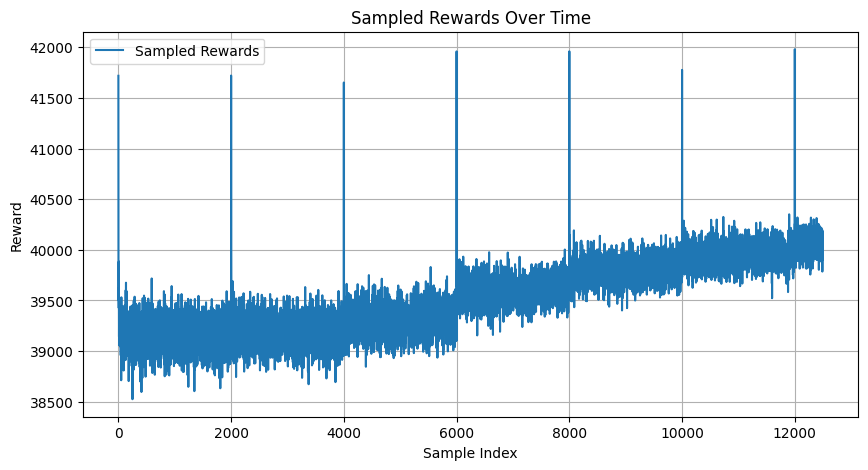

41981.7734375


In [ ]:
import torch
import matplotlib.pyplot as plt

sampled_rewards = torch.load("sampled_rewards.pt")

plt.figure(figsize=(10, 5))
plt.plot(sampled_rewards, label='Sampled Rewards')
plt.xlabel('Sample Index')
plt.ylabel('Reward')
plt.title('Sampled Rewards Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import abc
import torch
import numpy as np
from torch.utils.data import Dataset


def nll_unit_gaussian(data, sigma=1.0):
    data = data.view(data.shape[0], -1)
    loss = 0.5 * np.log(2 * np.pi) + np.log(sigma) + 0.5 * data * data / (sigma ** 2)
    return torch.sum(torch.flatten(loss, start_dim=1), -1)


class BaseSet(abc.ABC, Dataset):
    def __init__(self, len_data=-2333):
        self.num_sample = len_data
        self.data = None
        self.data_ndim = None
        self._gt_ksd = None

    def gt_logz(self):
        raise NotImplementedError

    @abc.abstractmethod
    def energy(self, x):
        return

    def unnorm_pdf(self, x):
        return torch.exp(-self.energy(x))

    # hmt stands for hamiltonian
    def hmt_energy(self, x):
        dim = x.shape[-1]
        x, v = torch.split(x, dim // 2, dim=-1)
        neg_log_p_x = self.sample_energy_fn(x)
        neg_log_p_v = nll_unit_gaussian(v)
        return neg_log_p_x + neg_log_p_v

    @property
    def ndim(self):
        return self.data_ndim

    def sample(self, batch_size):
        del batch_size
        raise NotImplementedError

    def score(self, x):
        with torch.no_grad():
            copy_x = x.detach().clone()
            copy_x.requires_grad = True
            with torch.enable_grad():
                self.energy(copy_x).sum().backward()
                lgv_data = copy_x.grad.data
            return lgv_data

    def log_reward(self, x):
        return -self.energy(x)

    def hmt_score(self, x):
        with torch.no_grad():
            copy_x = x.detach().clone()
            copy_x.requires_grad = True
            with torch.enable_grad():
                self.hmt_energy(copy_x).sum().backward()
                lgv_data = copy_x.grad.data
            return lgv_data

In [10]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily


def rejection_sampling(n_samples: int, proposal: torch.distributions.Distribution,
                       target_log_prob_fn: Callable, k: float) -> torch.Tensor:
    """Rejection sampling. See Pattern Recognition and ML by Bishop Chapter 11.1"""
    z_0 = proposal.sample((n_samples*10,))
    u_0 = torch.distributions.Uniform(0, k*torch.exp(proposal.log_prob(z_0)))\
        .sample().to(z_0)
    accept = torch.exp(target_log_prob_fn(z_0)) > u_0
    samples = z_0[accept]
    if samples.shape[0] >= n_samples:
        return samples[:n_samples]
    else:
        required_samples = n_samples - samples.shape[0]
        new_samples = rejection_sampling(required_samples, proposal, target_log_prob_fn, k)
        samples = torch.concat([samples, new_samples], dim=0)
        return samples


class ManyWell(BaseSet):
    """
    log p(x1, x2) = −x1^4 + 6*x1^2 + 1/2*x1 − 1/2*x2^2 + constant
    """
    def __init__(self, device, dim=32, is_linear=True):
        super().__init__()
        self.device = device

        self.data = torch.ones(dim, dtype=float).to(self.device)
        self.data_ndim = dim

        assert dim % 2 == 0
        self.n_wells = dim // 2

        # as rejection sampling proposal
        self.component_mix = torch.tensor([0.2, 0.8])
        self.means = torch.tensor([-1.7, 1.7])
        self.scales = torch.tensor([0.5, 0.5])

        self.Z_x1 = 11784.50927
        self.logZ_x2 = 0.5 * np.log(2 * np.pi)
        self.logZ_doublewell = np.log(self.Z_x1) + self.logZ_x2

    def gt_logz(self):
        return self.n_wells * self.logZ_doublewell

    def energy(self, x):
        return -self.manywell_logprob(x)

    def doublewell_logprob(self, x):
        assert x.shape[1] == 2 and x.ndim == 2
        x1 = x[:, 0]
        x2 = x[:, 1]
        x1_term = 0.5*x1 + 6*x1.pow(2) - x1.pow(4)
        x2_term = -0.5*x2.pow(2)
        return x1_term + x2_term

    def manywell_logprob(self, x):
        assert x.ndim == 2
        logprob = torch.stack(
            [self.doublewell_logprob(x[:, i*2:i*2+2]) for i in range(self.n_wells)],
        dim=1).sum(dim=1)
        return logprob

    def sample_first_dimension(self, batch_size):
        def target_log_prob(x):
            return -x ** 4 + 6 * x ** 2 + 1 / 2 * x

        # Define proposal
        mix = torch.distributions.Categorical(self.component_mix)
        com = torch.distributions.Normal(self.means, self.scales)
        proposal = torch.distributions.MixtureSameFamily(mixture_distribution=mix,
                                                         component_distribution=com)

        k = self.Z_x1 * 3
        samples = rejection_sampling(batch_size, proposal, target_log_prob, k)
        return samples

    def sample_doublewell(self, batch_size):
        x1 = self.sample_first_dimension(batch_size)
        x2 = torch.randn_like(x1)
        return torch.stack([x1, x2], dim=1)

    def sample(self, batch_size):
        return torch.cat(
            [self.sample_doublewell(batch_size) for _ in range(self.n_wells)],
        dim=-1)

    def viz_pdf(self, fsave="density.png", lim=3):
        raise NotImplementedError

    def __getitem__(self, idx):
        del idx
        return self.data[0]

In [13]:
device = 'cuda'

many_well_energy = ManyWell(device=device, dim=128)

# many_well_samples = many_well_energy.sample(600000).to(device)
# many_well_rewards = many_well_energy.log_reward(many_well_samples).to(device)

print(many_well_energy.gt_logz())

658.7827012791876


In [7]:
import torch
what = torch.load("true_data/many_well/samples.pt")

print(what.shape[-1])

32
